# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
svm = LinearSVM()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        
        y_train_pred = svm.predict(X_train_feats)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

50000.0
0.0014764166246658524
50000.0
0.0014761213807171522
50000.0
0.0014758261895257074
50000.0
0.001475531068716669
50000.0
0.0014752359787266241
50000.0
0.001474940949778589
50000.0
0.001474645988249075
50000.0
0.0014743510920313758
50000.0
0.0014740562753528612
50000.0
0.001473761501937194
50000.0
0.0014734667886358152
50000.0
0.0014731721645327319
50000.0
0.001472877570741252
50000.0
0.001472583059780565
50000.0
0.0014722886118317083
50000.0
0.0014719942142857666
50000.0
0.0014716998483915366
50000.0
0.0014714055578368946
50000.0
0.0014711113095521539
50000.0
0.0014708171244053598
50000.0
0.0014705229884222066
50000.0
0.0014702289265959064
50000.0
0.0014699349379233258
50000.0
0.0014696409813424358
50000.0
0.001469347096023059
50000.0
0.001469053251146708
50000.0
0.001468759466009112
50000.0
0.0014684657372398982
50000.0
0.001468172060950727
50000.0
0.0014678784454283148
50000.0
0.0014675848952137053
50000.0
0.0014672914103776454
50000.0
0.0014669979929816334
50000.0
0.0014667046

50000.0
0.0013566517006931666
50000.0
0.0013563803984117044
50000.0
0.0013561091542481736
50000.0
0.001355837976397801
50000.0
0.0013555668177857153
50000.0
0.0013552957681385557
50000.0
0.0013550247562640026
50000.0
0.0013547537844431135
50000.0
0.0013544828657865542
50000.0
0.0013542119823087679
50000.0
0.0013539411796468649
50000.0
0.0013536704085838134
50000.0
0.001353399726892159
50000.0
0.0013531290686115776
50000.0
0.0013528584669748591
50000.0
0.0013525879168850199
50000.0
0.0013523174319597722
50000.0
0.0013520469949545614
50000.0
0.0013517766323071438
50000.0
0.0013515063164878075
50000.0
0.0013512360436118928
50000.0
0.0013509658268559955
50000.0
0.0013506956573805236
50000.0
0.0013504255710270086
50000.0
0.001350155504123064
50000.0
0.0013498854967448986
50000.0
0.0013496155519966265
50000.0
0.0013493456338726732
50000.0
0.001349075789745944
50000.0
0.0013488060227294678
50000.0
0.0013485362846962258
50000.0
0.001348266614766963
50000.0
0.0013479969728727652
50000.0
0.00134

50000.0
0.0012495975824414435
50000.0
0.0012493476888862701
50000.0
0.0012490978597339765
50000.0
0.001248848078626258
50000.0
0.0012485983153387743
50000.0
0.0012483486231799632
50000.0
0.0012480989933393969
50000.0
0.0012478494082356006
50000.0
0.0012475998791913463
50000.0
0.0012473503798622807
50000.0
0.001247100947795775
50000.0
0.0012468515442632716
50000.0
0.0012466021910383627
50000.0
0.0012463529072115416
50000.0
0.0012461036701519512
50000.0
0.001245854464658612
50000.0
0.0012456053155356218
50000.0
0.001245356240541117
50000.0
0.0012451071991925777
50000.0
0.0012448581937928023
50000.0
0.0012446092402581543
50000.0
0.0012443603591497283
50000.0
0.001244111540651414
50000.0
0.0012438627466332633
50000.0
0.0012436140097627274
50000.0
0.001243365339683993
50000.0
0.0012431166943540602
50000.0
0.0012428681058536117
50000.0
0.0012426195603163336
50000.0
0.0012423710507721824
50000.0
0.001242122617187927
50000.0
0.0012418742332386224
50000.0
0.0012416258932179906
50000.0
0.0012413

50000.0
0.001145480477189122
50000.0
0.0011452514146883174
50000.0
0.001145022403317221
50000.0
0.0011447934352184102
50000.0
0.001144564499636056
50000.0
0.0011443356133744097
50000.0
0.0011441067628271558
50000.0
0.0011438779853816606
50000.0
0.0011436492251923173
50000.0
0.001143420527840385
50000.0
0.0011431918989885036
50000.0
0.00114296326182385
50000.0
0.001142734696740573
50000.0
0.0011425061648458312
50000.0
0.0011422777090471362
50000.0
0.0011420492906069565
50000.0
0.0011418209145124968
50000.0
0.0011415925733153272
50000.0
0.0011413642755495877
50000.0
0.0011411360573985382
50000.0
0.0011409078413200419
50000.0
0.0011406796887677667
50000.0
0.00114045160470731
50000.0
0.0011402235377450493
50000.0
0.0011399955203577113
50000.0
0.001139767565906071
50000.0
0.0011395396472961205
50000.0
0.0011393117586246753
50000.0
0.0011390839016724866
50000.0
0.0011388561166930434
50000.0
0.0011386283738279825
50000.0
0.0011384006733706482
50000.0
0.0011381730290516093
50000.0
0.0011379454

500000.0
0.000841555824323464
500000.0
0.0008398735989591767
500000.0
0.0008381947155412042
500000.0
0.000836519176170177
500000.0
0.0008348469996671131
500000.0
0.000833178149084981
500000.0
0.0008315126569714926
500000.0
0.0008298504928860436
500000.0
0.0008281916546200104
500000.0
0.000826536144380517
500000.0
0.0008248839059779712
500000.0
0.0008232349701026564
500000.0
0.0008215893306707468
500000.0
0.0008199470037611363
500000.0
0.0008183079419048732
500000.0
0.0008166721834110078
500000.0
0.0008150396650778909
500000.0
0.0008134104099171808
500000.0
0.000811784407406591
500000.0
0.0008101616845112983
500000.0
0.0008085421587168144
500000.0
0.0008069258926647923
500000.0
0.0008053128564921204
500000.0
0.0008037030456185477
500000.0
0.0008020964541392208
500000.0
0.000800493084540701
500000.0
0.0007988929247101197
500000.0
0.0007972959359457944
500000.0
0.0007957021699331668
500000.0
0.0007941115535641198
500000.0
0.0007925241412501638
500000.0
0.0007909399081185545
500000.0
0.000

500000.0
0.00032272001760738156
500000.0
0.0003220749191555479
500000.0
0.00032143111130196467
500000.0
0.0003207885852362336
500000.0
0.0003201473421345521
500000.0
0.0003195073728340841
500000.0
0.000318868691461846
500000.0
0.0003182312837429316
500000.0
0.0003175951470842304
500000.0
0.00031696028158587146
500000.0
0.0003163266858322753
500000.0
0.0003156943620320291
500000.0
0.00031506329705724553
500000.0
0.00031443349506395785
500000.0
0.00031380494811778024
500000.0
0.00031317766269138895
500000.0
0.00031255164302564466
500000.0
0.0003119268740370737
500000.0
0.00031130334243344355
500000.0
0.0003106810499427151
500000.0
0.0003100600130900233
500000.0
0.00030944020890755273
500000.0
0.0003088216514110294
500000.0
0.00030820433021782424
500000.0
0.0003075882492848516
500000.0
0.0003069733988698835
500000.0
0.00030635976635661724
500000.0
0.0003057473556195275
500000.0
0.0003051361770282747
500000.0
0.0003045262215993948
500000.0
0.0003039174823425847
500000.0
0.00030330996540418

500000.0
0.0001257548041800414
500000.0
0.00012550342408098805
500000.0
0.00012525255323598256
500000.0
0.0001250021750961499
500000.0
0.00012475229942975448
500000.0
0.0001245029314718238
500000.0
0.00012425406012996358
500000.0
0.0001240056856997134
500000.0
0.0001237578001712905
500000.0
0.00012351041891914643
500000.0
0.00012326352286543202
500000.0
0.0001230171276359089
500000.0
0.00012277122815954582
500000.0
0.00012252581492617245
500000.0
0.00012228089394062828
500000.0
0.00012203645466778488
500000.0
0.00012179251712503968
500000.0
0.00012154905933179857
500000.0
0.00012130609018502258
500000.0
0.00012106361244536106
500000.0
0.00012082161249468996
500000.0
0.00012058009290652198
500000.0
0.0001203390575998934
500000.0
0.00012009851300061894
500000.0
0.00011985844503745802
500000.0
0.0001196188506346072
500000.0
0.00011937973499999528
500000.0
0.00011914110211487912
500000.0
0.00011890294028759072
500000.0
0.00011866525333855275
500000.0
0.00011842804499740988
500000.0
0.00011

5000000.0
5.1194860536589955e-05
5000000.0
5.0176087189350834e-05
5000000.0
4.9177585777366683e-05
5000000.0
4.819894955940917e-05
5000000.0
4.723979625810167e-05
5000000.0
4.6299730479362625e-05
5000000.0
4.53783691545882e-05
5000000.0
4.44753412774076e-05
5000000.0
4.359028649110481e-05
5000000.0
4.2722841359318806e-05
5000000.0
4.187265830620955e-05
5000000.0
4.1039394046478604e-05
5000000.0
4.022271288106929e-05
5000000.0
3.942228638267135e-05
5000000.0
3.863778653266382e-05
5000000.0
3.786889527536934e-05
5000000.0
3.711531136204215e-05
5000000.0
3.637671960676317e-05
5000000.0
3.565282495330032e-05
5000000.0
3.494333559324118e-05
5000000.0
3.424796524841059e-05
5000000.0
3.356643582519074e-05
5000000.0
3.289846256010793e-05
5000000.0
3.2243787636861016e-05
5000000.0
3.160213794322369e-05
5000000.0
3.0973256661828594e-05
5000000.0
3.0356888511281014e-05
5000000.0
2.9752789796221905e-05
5000000.0
2.9160713785787226e-05
5000000.0
2.8580419872975883e-05
5000000.0
2.8011671571738202e-

5000000.0
5.3566673432664324e-09
5000000.0
5.2501062062526895e-09
5000000.0
5.145737112625014e-09
5000000.0
5.043399423055948e-09
5000000.0
4.943117392981281e-09
5000000.0
4.844791549632631e-09
5000000.0
4.748443045251192e-09
5000000.0
4.654020862463883e-09
5000000.0
4.561470664925033e-09
5000000.0
4.470774261687206e-09
5000000.0
4.3818500646938165e-09
5000000.0
4.2947251591534365e-09
5000000.0
4.20933271647509e-09
5000000.0
4.125633835817591e-09
5000000.0
4.043611200277043e-09
5000000.0
3.963207174357684e-09
5000000.0
3.884356101478089e-09
5000000.0
3.807121430322613e-09
5000000.0
3.7314542335859545e-09
5000000.0
3.657295711613846e-09
5000000.0
3.5845236127644365e-09
5000000.0
3.513219900562058e-09
5000000.0
3.4433361339331675e-09
5000000.0
3.3748309816263134e-09
5000000.0
3.3077375509209676e-09
5000000.0
3.2419918740886758e-09
5000000.0
3.177522388825661e-09
5000000.0
3.1143175261870783e-09
5000000.0
3.0523964346295627e-09
5000000.0
2.9916920952449604e-09
5000000.0
2.932212226512763e

5000000.0
1.1570883602161747e-11
5000000.0
1.135559896839251e-11
5000000.0
1.1140826856017937e-11
5000000.0
1.093360331070807e-11
5000000.0
1.0731588632561003e-11
5000000.0
1.0535378218946471e-11
5000000.0
1.0338923400325583e-11
5000000.0
1.0146800407302305e-11
5000000.0
9.95855685207278e-12
5000000.0
9.774831978403891e-12
5000000.0
9.596544721939295e-12
5000000.0
9.421274752749667e-12
5000000.0
9.251009168270041e-12
5000000.0
9.081961394662149e-12
5000000.0
8.91591030454227e-12
5000000.0
8.753825865082802e-12
5000000.0
8.595259736925346e-12
5000000.0
8.43738778485496e-12
5000000.0
8.284403328647896e-12
5000000.0
8.13565295602053e-12
5000000.0
7.985481905842004e-12
5000000.0
7.840792415749571e-12
5000000.0
7.695980813625301e-12
5000000.0
7.555014394440379e-12
5000000.0
7.4212799691619e-12
5000000.0
7.287458438279757e-12
5000000.0
7.1568488872473956e-12
5000000.0
7.028806997620246e-12
5000000.0
6.902732342565076e-12
5000000.0
6.779607415919172e-12
5000000.0
6.658829220632273e-12
5000000

5000000.0
6.516047163581022e-13
5000000.0
6.511038260386025e-13
5000000.0
6.515716047745352e-13
5000000.0
6.515293330934994e-13
5000000.0
6.512764587183329e-13
5000000.0
6.503830589481474e-13
5000000.0
6.500010017447383e-13
5000000.0
6.500438771879258e-13
5000000.0
6.497635936346648e-13
5000000.0
6.493763716377852e-13
5000000.0
6.484402937529743e-13
5000000.0
6.489248566104361e-13
5000000.0
6.472992794394753e-13
5000000.0
6.460070459469855e-13
5000000.0
6.451948368737866e-13
5000000.0
6.427065328254911e-13
5000000.0
6.424117351650112e-13
5000000.0
6.437843721542897e-13
5000000.0
6.425364778164048e-13
5000000.0
6.416920159695233e-13
5000000.0
6.420924886831652e-13
5000000.0
6.417063520350853e-13
5000000.0
6.417773773084901e-13
5000000.0
6.410901033845392e-13
5000000.0
6.413550263875695e-13
5000000.0
6.419567854582778e-13
5000000.0
6.415456119496821e-13
5000000.0
6.415372465658952e-13
5000000.0
6.402954988625364e-13
5000000.0
6.403334770300206e-13
5000000.0
6.398685367633966e-13
5000000.

5000000.0
6.319151300126531e-13
5000000.0
6.335885957250569e-13
5000000.0
6.339293526258146e-13
5000000.0
6.337880199004051e-13
5000000.0
6.338307710740046e-13
5000000.0
6.321985999166265e-13
5000000.0
6.324443939996175e-13
5000000.0
6.322093101730993e-13
5000000.0
6.332713434477248e-13
5000000.0
6.334068274881971e-13
5000000.0
6.321138620147664e-13
5000000.0
6.335876645454603e-13
5000000.0
6.340558575070987e-13
5000000.0
6.336302455706885e-13
5000000.0
6.309067824013105e-13
5000000.0
6.309913448409354e-13
50000.0
6.319012653616812e-13
50000.0
7.799721482863773e-13
50000.0
9.12750633702981e-13
50000.0
1.0759056132477465e-12
50000.0
1.2472644520689595e-12
50000.0
1.4156017787265355e-12
50000.0
1.596237436602416e-12
50000.0
1.7788042894968093e-12
50000.0
2.0020649935566363e-12
50000.0
2.252959212580067e-12
50000.0
2.4867076648614907e-12
50000.0
2.7674281745777213e-12
50000.0
3.03546014197897e-12
50000.0
3.2959754542877885e-12
50000.0
3.6201784432116393e-12
50000.0
3.9400089276685195e-12


50000.0
8.83392914892711e-10
50000.0
8.857802893443726e-10
50000.0
8.883890697356957e-10
50000.0
8.90802428293578e-10
50000.0
8.942820460396186e-10
50000.0
8.970245449286198e-10
50000.0
8.999348670870967e-10
50000.0
9.028884762536012e-10
50000.0
9.050428300173084e-10
50000.0
9.077165932810917e-10
50000.0
9.103665491142324e-10
50000.0
9.133557774182831e-10
50000.0
9.167212142137983e-10
50000.0
9.192076625371281e-10
50000.0
9.219675195316494e-10
50000.0
9.250536160977842e-10
50000.0
9.277707848423194e-10
50000.0
9.307617254179244e-10
50000.0
9.33680556108766e-10
50000.0
9.360275592216675e-10
50000.0
9.389089409641361e-10
50000.0
9.420063410784934e-10
50000.0
9.4490889222679e-10
50000.0
9.482821576089084e-10
50000.0
9.51313829727255e-10
50000.0
9.5465390614449e-10
50000.0
9.5772981291673e-10
50000.0
9.604343886840786e-10
50000.0
9.633539926665734e-10
50000.0
9.655675018719118e-10
50000.0
9.681773524022688e-10
50000.0
9.713053590207257e-10
50000.0
9.73183259904029e-10
50000.0
9.75963611694

50000.0
2.195782431597873e-09
50000.0
2.1996519688822638e-09
50000.0
2.2023998608697014e-09
50000.0
2.205768246897465e-09
50000.0
2.209522865575849e-09
50000.0
2.212840487252189e-09
50000.0
2.2153507465410752e-09
50000.0
2.219417598709131e-09
50000.0
2.222474069205795e-09
50000.0
2.22406080649646e-09
50000.0
2.226827758981459e-09
50000.0
2.229449737241049e-09
50000.0
2.232608060758091e-09
50000.0
2.235607450438255e-09
50000.0
2.238512144131047e-09
50000.0
2.241841938577575e-09
50000.0
2.24429013820467e-09
50000.0
2.247814522016677e-09
50000.0
2.25060912049882e-09
50000.0
2.2535367488908966e-09
50000.0
2.256627688777392e-09
50000.0
2.2596694206165716e-09
50000.0
2.2624816613782465e-09
50000.0
2.2650743423487452e-09
50000.0
2.2673881935404223e-09
50000.0
2.2703065562650837e-09
50000.0
2.273411790251952e-09
50000.0
2.276375260860268e-09
50000.0
2.2782853729201877e-09
50000.0
2.2810290222754524e-09
50000.0
2.2845967864795658e-09
50000.0
2.287787408602415e-09
50000.0
2.291122750565558e-09
5

50000.0
3.156407011015499e-09
50000.0
3.1585155313092525e-09
50000.0
3.161504274808712e-09
50000.0
3.164271310061389e-09
50000.0
3.1662666049851824e-09
50000.0
3.169508037350178e-09
50000.0
3.1726780497317607e-09
50000.0
3.175591868620324e-09
50000.0
3.17866403350328e-09
50000.0
3.181187021363738e-09
50000.0
3.1841163854452518e-09
50000.0
3.1865793844759406e-09
50000.0
3.1903659399158866e-09
50000.0
3.192839337152839e-09
50000.0
3.1959377740855338e-09
50000.0
3.197641454455968e-09
50000.0
3.2001740182198286e-09
50000.0
3.2017825994813483e-09
50000.0
3.2041336113220037e-09
50000.0
3.2064646294115423e-09
50000.0
3.2091587956202037e-09
50000.0
3.2119241281827936e-09
50000.0
3.214559707487885e-09
50000.0
3.2166883380606106e-09
50000.0
3.218529346507401e-09
50000.0
3.220765281296332e-09
50000.0
3.2232461621512807e-09
50000.0
3.226150644703451e-09
50000.0
3.2296248737494536e-09
50000.0
3.2328347763960916e-09
50000.0
3.235771046529873e-09
50000.0
3.2393670046022166e-09
50000.0
3.2415082701918

500000.0
7.055326896550857e-10
500000.0
6.961441020315652e-10
500000.0
6.864354403584619e-10
500000.0
6.770411873122196e-10
500000.0
6.676336484311334e-10
500000.0
6.58108079939327e-10
500000.0
6.489540153008869e-10
500000.0
6.400029784059937e-10
500000.0
6.308517272261851e-10
500000.0
6.225451182928149e-10
500000.0
6.141458009911901e-10
500000.0
6.060234338721924e-10
500000.0
5.970501217429007e-10
500000.0
5.888238551998147e-10
500000.0
5.805703252022431e-10
500000.0
5.72645485616971e-10
500000.0
5.64757908764193e-10
500000.0
5.571782757628229e-10
500000.0
5.500626052620834e-10
500000.0
5.434462890807504e-10
500000.0
5.364743576454046e-10
500000.0
5.294623274361822e-10
500000.0
5.226048432029957e-10
500000.0
5.160582200028718e-10
500000.0
5.096818531634931e-10
500000.0
5.027540749439828e-10
500000.0
4.960832419375363e-10
500000.0
4.896934598511622e-10
500000.0
4.837416754390032e-10
500000.0
4.77206253779928e-10
500000.0
4.711013599506415e-10
500000.0
4.648424409937798e-10
500000.0
4.5

500000.0
6.604614619087434e-11
500000.0
6.600279764411477e-11
500000.0
6.603831116813811e-11
500000.0
6.606658949808153e-11
500000.0
6.598065373761238e-11
500000.0
6.601905796380278e-11
500000.0
6.601119722193911e-11
500000.0
6.60916637164434e-11
500000.0
6.597012259888334e-11
500000.0
6.589814519211459e-11
500000.0
6.575909630717047e-11
500000.0
6.564628065937164e-11
500000.0
6.550971595910772e-11
500000.0
6.54342876930496e-11
500000.0
6.537794488106649e-11
500000.0
6.529978431315944e-11
500000.0
6.531687413143152e-11
500000.0
6.522129019890503e-11
500000.0
6.520091501446895e-11
500000.0
6.517849318488692e-11
500000.0
6.522314613622908e-11
500000.0
6.520532056073632e-11
500000.0
6.528083321339191e-11
500000.0
6.521391948812111e-11
500000.0
6.522554306790784e-11
500000.0
6.512116334147508e-11
500000.0
6.501089369148259e-11
500000.0
6.506181294867675e-11
500000.0
6.487391874383829e-11
500000.0
6.491160575480005e-11
500000.0
6.49096287445417e-11
500000.0
6.491019641834933e-11
500000.0
6.

500000.0
6.30056193975047e-11
500000.0
6.300128802766416e-11
500000.0
6.299986802554466e-11
500000.0
6.312872814196053e-11
500000.0
6.313087026686192e-11
500000.0
6.306934734095245e-11
500000.0
6.304283483180167e-11
500000.0
6.286985919200019e-11
500000.0
6.277697581720184e-11
500000.0
6.272196873219198e-11
500000.0
6.283748411471214e-11
500000.0
6.27392486722906e-11
500000.0
6.273622739711266e-11
500000.0
6.271964614498653e-11
500000.0
6.266891435982029e-11
500000.0
6.272597798018757e-11
500000.0
6.271709588762597e-11
500000.0
6.276147855228537e-11
500000.0
6.277223341333526e-11
500000.0
6.28141815238003e-11
500000.0
6.28046141632684e-11
500000.0
6.28831096494049e-11
500000.0
6.27912471452949e-11
500000.0
6.282175350753722e-11
500000.0
6.285680395519617e-11
500000.0
6.304968431961205e-11
500000.0
6.304531468599961e-11
500000.0
6.302955163011301e-11
500000.0
6.297227828119668e-11
500000.0
6.295687564846687e-11
500000.0
6.284692748114639e-11
500000.0
6.272752364933295e-11
500000.0
6.290

500000.0
6.335392845959689e-11
500000.0
6.329795298446153e-11
500000.0
6.315016388928432e-11
500000.0
6.310558347437015e-11
500000.0
6.311278684900965e-11
500000.0
6.312854719994328e-11
500000.0
6.305070004705176e-11
500000.0
6.320168236794172e-11
500000.0
6.312359784688465e-11
500000.0
6.315111168725792e-11
500000.0
6.316433904619603e-11
500000.0
6.300252453949425e-11
500000.0
6.301595372148552e-11
500000.0
6.309966622847943e-11
500000.0
6.32251770614093e-11
500000.0
6.31341507274787e-11
500000.0
6.324977579437858e-11
500000.0
6.318944503616423e-11
500000.0
6.325652516402287e-11
500000.0
6.32492385550261e-11
500000.0
6.325914449282425e-11
500000.0
6.323530158803696e-11
500000.0
6.340710910567193e-11
500000.0
6.333811067783741e-11
500000.0
6.333541851793506e-11
500000.0
6.312377683708775e-11
500000.0
6.309132575594136e-11
500000.0
6.311796172943255e-11
500000.0
6.311113727256563e-11
500000.0
6.316668619360236e-11
500000.0
6.316344131516174e-11
500000.0
6.295602198918192e-11
500000.0
6.

5000000.0
6.746126727294636e-13
5000000.0
6.753045701495636e-13
5000000.0
6.575528558550117e-13
5000000.0
6.58294640711319e-13
5000000.0
6.686064486532602e-13
5000000.0
6.892358796724822e-13
5000000.0
6.789180742277287e-13
5000000.0
6.735117998984325e-13
5000000.0
6.640733958380454e-13
5000000.0
6.565247861198758e-13
5000000.0
6.551672973579639e-13
5000000.0
6.510818784500403e-13
5000000.0
6.518531477994322e-13
5000000.0
6.474484734050048e-13
5000000.0
6.458330632599797e-13
5000000.0
6.432696825543612e-13
5000000.0
6.499458466490184e-13
5000000.0
6.67524563104872e-13
5000000.0
6.578648550039269e-13
5000000.0
6.715424964790187e-13
5000000.0
6.767387359722726e-13
5000000.0
6.870344862711912e-13
5000000.0
6.973374044180731e-13
5000000.0
6.923997901910547e-13
5000000.0
6.92030501816891e-13
5000000.0
6.776262432437463e-13
5000000.0
6.648738642375569e-13
5000000.0
6.671682765266221e-13
5000000.0
6.521287154730572e-13
5000000.0
6.565493536613551e-13
5000000.0
6.628001184021411e-13
5000000.0
6

5000000.0
6.802268977113587e-13
5000000.0
6.81498792470398e-13
5000000.0
6.913754994594886e-13
5000000.0
6.954490082598072e-13
5000000.0
6.968452373575481e-13
5000000.0
6.912454095559438e-13
5000000.0
7.098017262507007e-13
5000000.0
7.001491474485652e-13
5000000.0
6.988551129337164e-13
5000000.0
7.045503617260898e-13
5000000.0
7.036289968597893e-13
5000000.0
7.024350115512726e-13
5000000.0
6.967099195980034e-13
5000000.0
6.935095303836425e-13
5000000.0
6.855974434628823e-13
5000000.0
6.988947843682505e-13
5000000.0
7.004479306233526e-13
5000000.0
7.174885553828744e-13
5000000.0
6.985035793892426e-13
5000000.0
6.875823694388532e-13
5000000.0
6.726801147331617e-13
5000000.0
6.721257335140012e-13
5000000.0
6.752585558296297e-13
5000000.0
6.827359137349009e-13
5000000.0
6.685736903212163e-13
5000000.0
6.690549771491862e-13
5000000.0
6.67096942991615e-13
5000000.0
6.462602956761901e-13
5000000.0
6.541921483983496e-13
5000000.0
6.591646983965575e-13
5000000.0
6.523517404489461e-13
5000000.0


5000000.0
6.503417743133412e-13
5000000.0
6.355323274365265e-13
5000000.0
6.437941019099087e-13
5000000.0
6.600206027077685e-13
5000000.0
6.627883013624064e-13
5000000.0
6.654869405095996e-13
5000000.0
6.675699945937777e-13
5000000.0
6.630573662166124e-13
5000000.0
6.633187007817152e-13
5000000.0
6.690383256563085e-13
5000000.0
6.559352280179578e-13
5000000.0
6.55156390620329e-13
5000000.0
6.553979458816895e-13
5000000.0
6.59118987674778e-13
5000000.0
6.777934094019215e-13
5000000.0
6.775985006527977e-13
5000000.0
6.911256659333924e-13
5000000.0
6.731443105228963e-13
5000000.0
6.710413524996415e-13
5000000.0
6.695180115302117e-13
5000000.0
6.792716213705905e-13
5000000.0
6.758382476672199e-13
5000000.0
6.602305795788947e-13
5000000.0
6.679100833541275e-13
5000000.0
6.712271185918328e-13
5000000.0
6.782254286198854e-13
5000000.0
6.767969627027423e-13
5000000.0
6.830041344111505e-13
5000000.0
6.764966387841121e-13
5000000.0
6.830561167987253e-13
5000000.0
7.045128964037649e-13
5000000.0


50000.0
2.415326249190366e-10
50000.0
2.568002383027987e-10
50000.0
2.776599489091945e-10
50000.0
2.996714295209211e-10
50000.0
3.192410048641984e-10
50000.0
3.4264015540651955e-10
50000.0
3.640373214502934e-10
50000.0
3.855564390777301e-10
50000.0
4.1268168896553387e-10
50000.0
4.4038219732676263e-10
50000.0
4.6392021454718915e-10
50000.0
4.910538491665914e-10
50000.0
5.167391184782239e-10
50000.0
5.444825671613383e-10
50000.0
5.722312745020677e-10
50000.0
5.996418627494151e-10
50000.0
6.29214065712261e-10
50000.0
6.558185631840585e-10
50000.0
6.873122413407945e-10
50000.0
7.145380602829038e-10
50000.0
7.378633408732822e-10
50000.0
7.728536981157591e-10
50000.0
7.994742122711631e-10
50000.0
8.290722544015278e-10
50000.0
8.588395071183071e-10
50000.0
8.880665512851032e-10
50000.0
9.185896855776521e-10
50000.0
9.544663961941557e-10
50000.0
9.821121393175984e-10
50000.0
1.0150009591163457e-09
50000.0
1.0467411681629699e-09
50000.0
1.083937217589775e-09
50000.0
1.1105691488711156e-09
5000

50000.0
6.16655415796046e-09
50000.0
6.161111873318693e-09
50000.0
6.157959638327512e-09
50000.0
6.1537498869997794e-09
50000.0
6.154398415248177e-09
50000.0
6.161478197457325e-09
50000.0
6.16198624882576e-09
50000.0
6.160600358105181e-09
50000.0
6.171581403216142e-09
50000.0
6.166588521318307e-09
50000.0
6.176658261560053e-09
50000.0
6.187686367064087e-09
50000.0
6.1801474187230136e-09
50000.0
6.194313744493243e-09
50000.0
6.1882885001696794e-09
50000.0
6.187799118028551e-09
50000.0
6.1799884236491626e-09
50000.0
6.168808476857118e-09
50000.0
6.167613998620656e-09
50000.0
6.158663712248056e-09
50000.0
6.165730110770598e-09
50000.0
6.155961249915128e-09
50000.0
6.160549708017786e-09
50000.0
6.165387971581774e-09
50000.0
6.170734403927952e-09
50000.0
6.1788816950341525e-09
50000.0
6.166838616859193e-09
50000.0
6.177233166427993e-09
50000.0
6.181490835340933e-09
50000.0
6.1895998377237655e-09
50000.0
6.174413304158289e-09
50000.0
6.1725876768014014e-09
50000.0
6.186777974542874e-09
50000

6.2696973855792926e-09
50000.0
6.280827911717546e-09
50000.0
6.281660611583264e-09
50000.0
6.283710137074924e-09
50000.0
6.282499906866427e-09
50000.0
6.2805934115413256e-09
50000.0
6.2675136943114714e-09
50000.0
6.267343816368638e-09
50000.0
6.256171769243458e-09
50000.0
6.251420561884279e-09
50000.0
6.250595213273485e-09
50000.0
6.255501788360707e-09
50000.0
6.242656273588445e-09
50000.0
6.257378676429991e-09
50000.0
6.275902443477891e-09
50000.0
6.279011129395376e-09
50000.0
6.283315916290927e-09
50000.0
6.276031769507229e-09
50000.0
6.275340796732277e-09
50000.0
6.273442482131562e-09
50000.0
6.287852362338814e-09
50000.0
6.289835004006566e-09
50000.0
6.2782423688502024e-09
50000.0
6.278271937746917e-09
50000.0
6.278195470231683e-09
50000.0
6.280179037089647e-09
50000.0
6.284103469181431e-09
50000.0
6.290797045200565e-09
50000.0
6.277511991679718e-09
50000.0
6.285844400994944e-09
50000.0
6.284768361976852e-09
50000.0
6.299844852125711e-09
50000.0
6.299364119397407e-09
50000.0
6.3011

50000.0
6.335360390040814e-09
50000.0
6.335125711646533e-09
50000.0
6.328462738087517e-09
50000.0
6.331688845642256e-09
50000.0
6.325145620148896e-09
50000.0
6.30903878693569e-09
50000.0
6.317700366226852e-09
50000.0
6.315935283196477e-09
50000.0
6.323113677681929e-09
50000.0
6.324986792598986e-09
50000.0
6.311806634091263e-09
50000.0
6.308385561750189e-09
50000.0
6.305147425838632e-09
50000.0
6.313279199531114e-09
50000.0
6.297201874623513e-09
50000.0
6.3029990688579e-09
50000.0
6.3082625742452555e-09
50000.0
6.308881263238525e-09
50000.0
6.3145279988079044e-09
50000.0
6.30934530233314e-09
50000.0
6.315248968395375e-09
50000.0
6.322511531869052e-09
50000.0
6.319992577813313e-09
50000.0
6.3046213640291785e-09
50000.0
6.298284556820672e-09
50000.0
6.3057323603142576e-09
50000.0
6.298673036881101e-09
50000.0
6.298171407207866e-09
50000.0
6.300602371165769e-09
50000.0
6.289200811462016e-09
50000.0
6.278888665911623e-09
50000.0
6.28129344812365e-09
50000.0
6.280545156677483e-09
50000.0
6.2

500000.0
9.024273609968824e-10
500000.0
7.74272780182012e-10
500000.0
6.690699761948961e-10
500000.0
5.863053722216527e-10
500000.0
5.120344236060595e-10
500000.0
4.464369830268497e-10
500000.0
3.936049036941769e-10
500000.0
3.495320669474271e-10
500000.0
3.110014260596108e-10
500000.0
2.771378543384149e-10
500000.0
2.4945397297440035e-10
500000.0
2.2723400987649633e-10
500000.0
2.0766526338946373e-10
500000.0
1.8930570527356547e-10
500000.0
1.7302246655766638e-10
500000.0
1.6188932962300588e-10
500000.0
1.520081203596714e-10
500000.0
1.4020701196068884e-10
500000.0
1.3161665013025815e-10
500000.0
1.2431856429243674e-10
500000.0
1.181585655341633e-10
500000.0
1.1138514965230346e-10
500000.0
1.0709101011450995e-10
500000.0
1.0375851288738967e-10
500000.0
9.877472067662553e-11
500000.0
9.407600587186459e-11
500000.0
9.026220076956757e-11
500000.0
8.903734149699524e-11
500000.0
8.834107218830264e-11
500000.0
8.428938056390813e-11
500000.0
8.247945489537078e-11
500000.0
8.08977040751643e-1

500000.0
6.66490439814257e-11
500000.0
6.74428055413023e-11
500000.0
6.76654778769675e-11
500000.0
6.799099238844008e-11
500000.0
6.618120912455273e-11
500000.0
6.5165970383498e-11
500000.0
6.622700315050462e-11
500000.0
6.674817096690746e-11
500000.0
6.65877527850911e-11
500000.0
6.835531362427207e-11
500000.0
6.793843475422733e-11
500000.0
6.99862559111481e-11
500000.0
7.066934959056055e-11
500000.0
6.96918697142196e-11
500000.0
7.084676296340066e-11
500000.0
7.303596780562946e-11
500000.0
7.311183538175685e-11
500000.0
7.147814560826186e-11
500000.0
7.116708842914805e-11
500000.0
7.136141615418908e-11
500000.0
7.021035212678536e-11
500000.0
6.902204240401153e-11
500000.0
6.794322884745485e-11
500000.0
6.729011931580846e-11
500000.0
6.728645185484366e-11
500000.0
6.739695633923739e-11
500000.0
6.635177806694909e-11
500000.0
6.629917831243819e-11
500000.0
6.56316061030982e-11
500000.0
6.597336365116967e-11
500000.0
6.521148426630853e-11
500000.0
6.49172990601832e-11
500000.0
6.4813250

500000.0
6.556984001812321e-11
500000.0
6.465923245456993e-11
500000.0
6.704166959776624e-11
500000.0
6.793054241065318e-11
500000.0
6.797184922212545e-11
500000.0
6.684402209976742e-11
500000.0
6.742943246278941e-11
500000.0
6.654193038981056e-11
500000.0
6.604063824369093e-11
500000.0
6.656549030889229e-11
500000.0
6.639325842950389e-11
500000.0
6.624959924492288e-11
500000.0
6.532452358606797e-11
500000.0
6.61220465939874e-11
500000.0
6.755893638935854e-11
500000.0
6.828946807379456e-11
500000.0
6.975930033502131e-11
500000.0
6.914286476390487e-11
500000.0
6.950448156726064e-11
500000.0
6.994865507795446e-11
500000.0
6.831578717903816e-11
500000.0
6.814264594576053e-11
500000.0
6.776261792488539e-11
500000.0
6.755656891233535e-11
500000.0
6.682482804982362e-11
500000.0
6.516432915983025e-11
500000.0
6.572290680883578e-11
500000.0
6.72682778475028e-11
500000.0
6.71748277567019e-11
500000.0
6.72992748467921e-11
500000.0
6.683818574751126e-11
500000.0
6.760918438221652e-11
500000.0
6.7

500000.0
7.054356033176845e-11
500000.0
7.055732722234152e-11
500000.0
7.132992648004995e-11
500000.0
7.126848066878626e-11
500000.0
7.088353407980217e-11
500000.0
7.011397742580016e-11
500000.0
6.915356015416323e-11
500000.0
6.822375749237144e-11
500000.0
6.796058156355409e-11
500000.0
6.802127089161237e-11
500000.0
6.652736020742936e-11
500000.0
6.679235106648726e-11
500000.0
6.705696999575521e-11
500000.0
6.718091452125247e-11
500000.0
6.726465398663301e-11
500000.0
6.698998545060809e-11
500000.0
6.572592684050628e-11
500000.0
6.679147828160998e-11
500000.0
6.614859944908658e-11
500000.0
6.622846170489084e-11
500000.0
6.563990790660083e-11
500000.0
6.562041041284829e-11
500000.0
6.527781327006914e-11
500000.0
6.637201767452892e-11
500000.0
6.684632109614002e-11
500000.0
6.612106262793649e-11
500000.0
6.530623558682132e-11
500000.0
6.423790086148656e-11
500000.0
6.452404694928694e-11
500000.0
6.514008493522575e-11
500000.0
6.47050798092854e-11
500000.0
6.507343568515188e-11
500000.0


5000000.0
1.427630059329957e-12
5000000.0
1.3306112262784523e-12
5000000.0
1.2969689404571639e-12
5000000.0
1.223002832009733e-12
5000000.0
1.398471888158723e-12
5000000.0
1.2973190729604883e-12
5000000.0
1.1308218248339617e-12
5000000.0
1.347150880789333e-12
5000000.0
1.1460664306026075e-12
5000000.0
1.2929129511383032e-12
5000000.0
1.3915345155087358e-12
5000000.0
1.314897984954472e-12
5000000.0
1.3741702451620304e-12
5000000.0
1.5161182916364356e-12
5000000.0
1.3305631233725168e-12
5000000.0
1.427897390632441e-12
5000000.0
1.4031551966283681e-12
5000000.0
1.343623737268093e-12
5000000.0
1.2402753923387002e-12
5000000.0
1.334109294128899e-12
5000000.0
1.2871741204573543e-12
5000000.0
1.361021425728084e-12
5000000.0
1.4198711833342364e-12
5000000.0
1.3934867434522042e-12
5000000.0
1.3765928306317733e-12
5000000.0
1.3880205453041279e-12
5000000.0
1.312559348907197e-12
5000000.0
1.4130643594877795e-12
5000000.0
1.2999877922564872e-12
5000000.0
1.3935129453488374e-12
5000000.0
1.27056345

5000000.0
1.3100562676399356e-12
5000000.0
1.2720028129141398e-12
5000000.0
1.2567935262773894e-12
5000000.0
1.4241482701354267e-12
5000000.0
1.3865793252200914e-12
5000000.0
1.466851019475327e-12
5000000.0
1.3477800568226664e-12
5000000.0
1.2866081465287261e-12
5000000.0
1.2939011606226664e-12
5000000.0
1.2580923563733463e-12
5000000.0
1.30987858161499e-12
5000000.0
1.2361798860205901e-12
5000000.0
1.2310893474728e-12
5000000.0
1.4441231216066199e-12
5000000.0
1.3764305492615074e-12
5000000.0
1.42205475101528e-12
5000000.0
1.2959157261905265e-12
5000000.0
1.2792793496741444e-12
5000000.0
1.6236500106639346e-12
5000000.0
1.2996236606720483e-12
5000000.0
1.3137545127001403e-12
5000000.0
1.330458885328889e-12
5000000.0
1.1642679698704994e-12
5000000.0
1.3176994902648648e-12
5000000.0
1.346004443315113e-12
5000000.0
1.1999725689043003e-12
5000000.0
1.276493429193251e-12
5000000.0
1.275021074035274e-12
5000000.0
1.2809445729987046e-12
5000000.0
1.4629589346460577e-12
5000000.0
1.3711039495

5000000.0
1.175013626337232e-12
5000000.0
1.133862940070998e-12
5000000.0
1.3929841462303293e-12
5000000.0
1.4217853791263298e-12
5000000.0
1.4016659601470687e-12
5000000.0
1.466832127970264e-12
5000000.0
1.3070141427650095e-12
5000000.0
1.521510712015756e-12
5000000.0
1.1420006719514575e-12
5000000.0
1.1083635451446049e-12
5000000.0
1.2630171370639312e-12
5000000.0
1.4988100457658149e-12
5000000.0
1.3273305364436553e-12
5000000.0
1.4719273375931225e-12
5000000.0
1.2930903743858882e-12
5000000.0
1.3482796089816821e-12
5000000.0
1.1379095077236138e-12
5000000.0
1.3605917637514166e-12
5000000.0
1.1601151650333892e-12
5000000.0
1.193333232023154e-12
5000000.0
1.288271013819461e-12
5000000.0
1.4424707157315879e-12
5000000.0
1.3373262859563331e-12
5000000.0
1.2604759574435612e-12
5000000.0
1.3693011658944339e-12
5000000.0
1.2815840959730314e-12
5000000.0
1.5127774257161765e-12
5000000.0
1.541660084783945e-12
5000000.0
1.1558199566258033e-12
5000000.0
1.4877263358504371e-12
5000000.0
1.38538

5000000.0
1.1012869526177386e-12
5000000.0
1.3354995235233754e-12
5000000.0
1.3378195103131368e-12
5000000.0
1.3026481541588396e-12
5000000.0
1.275053515022048e-12
5000000.0
1.2775939752997519e-12
5000000.0
1.3212098428304063e-12
5000000.0
1.2295627894294903e-12
5000000.0
1.3627627340324505e-12
5000000.0
1.3978512114639317e-12
5000000.0
1.4157508783217283e-12
5000000.0
1.2855051806805238e-12
5000000.0
1.2761161781064516e-12
5000000.0
1.2867572643410683e-12
5000000.0
1.3144975973622559e-12
5000000.0
1.209241688723951e-12
5000000.0
1.2968818842448404e-12
5000000.0
1.2825998504973833e-12
5000000.0
1.2132889616865953e-12
5000000.0
1.2447739411862157e-12
5000000.0
1.340553814891166e-12
5000000.0
1.2727106972667224e-12
5000000.0
1.3055554550096479e-12
5000000.0
1.4469825269923673e-12
5000000.0
1.2099281220164621e-12
5000000.0
1.163462865435875e-12
5000000.0
1.4693801294413213e-12
5000000.0
1.2299387128593797e-12
5000000.0
1.4276478988383847e-12
5000000.0
1.2152134117731229e-12
5000000.0
1.29

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.308


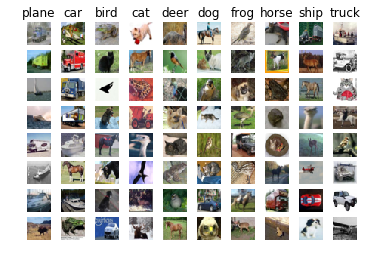

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
print(X_train_feats.shape)

(49000, 155)


In [9]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

hidden_size = [200]
learning_rate = [1]
reg = [1e-4]
best_acc = -1

log = {}

for hs in hidden_size:
    for lr in learning_rate:
        for r in reg:
            
            # Set up the network
            net = TwoLayerNet(input_dim, hs, num_classes)

            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=1000, batch_size=200,
                        learning_rate=lr, learning_rate_decay=0.95,
                        reg=r, verbose=False)
            
            acc = stats['val_acc_history'][-1]
            log[(hs, lr, r)] = acc
            
            # Print Log
            print('for hs: %e, lr: %e and r: %e, valid accuracy is: %f' 
                    % (hs, lr, r, acc))
            
            if acc > best_acc:
                best_net = net
                best_acc = acc
                
print('Best Networks has an Accuracy of: %f' % best_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

for hs: 2.000000e+02, lr: 1.000000e+00 and r: 1.000000e-04, valid accuracy is: 0.551000
Best Networks has an Accuracy of: 0.551000


In [10]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.511


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!